In [73]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from PIL import Image
import cv2

# Load data 
Load data from the folders. The output will be a list of tuples, containing the path to image and the label. 

In [53]:

# display current directory
print(os.getcwd())

# get Image path
#TRAIN_CLASS_PATH = r'../../asl_alphabet_train/asl_alphabet_train'
# train the landmark data
TRAIN_CLASS_PATH = r'../../asl_data_landmarked'
# TEST_CLASS_PATH = r'../asl_alphabet_test/asl_alphabet_test'

#TRAIN_CLASS_PATH = r'..\data\asl_alphabet_train\asl_alphabet_train'
#TEST_CLASS_PATH = r'..\data\asl_alphabet_test\asl_alphabet_test'

# hold class labels 
asl_classes = sorted(os.listdir(TRAIN_CLASS_PATH))
trainImages = []
image_label_paths = [] # used for customized dataset 

for i, class_name in enumerate(asl_classes):
    class_path = os.path.join(TRAIN_CLASS_PATH, class_name)
    fnames = os.listdir(class_path)
    for f in fnames:
        f_path = os.path.join(TRAIN_CLASS_PATH,class_name, f)
        trainImages.append(f_path)
        image_label_paths.append((f_path, i))

# # display class names 
print(os.getcwd())
print(asl_classes)
print(len(image_label_paths))
print(image_label_paths[0])

/home/jupyter-suh222/Hand-Gesuture-CV-24/src/model
/home/jupyter-suh222/Hand-Gesuture-CV-24/src/model
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
75031
('../../asl_data_landmarked/A/landmarked_A1939.jpg', 0)


# Data Preprocessing 


In [54]:
# Create the Dataset ibject using torch 

BATCH_SIZE = 32
transform = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
        ])

class CustomDataset(Dataset):
    def __init__(self, image_label_paths,transform=None):
        # store image path
        self.image_label_paths = image_label_paths
        self.transform = transform
    
    def __len__(self):
        # return the number of total sampels in the dataset
        return len(self.image_label_paths)
    
    def __getitem__(self, index):
        imagePath, label = self.image_label_paths[index]
        
        #image = cv2.imread(imagePath)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.open(imagePath).convert('RGB')
        if self.transform is not None:
            # apply transoformation 
            image = self.transform(image)
        return image, label


class ImageDataset(LightningModule):
    def __init__(self, image_label_paths, batch_size = BATCH_SIZE):
        super().__init__()
        
        self.image_label_paths = image_label_paths
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
        ])
    def __len__(self):
        if self.trainDS is not None:
            return len(self.trainDS)
        elif self.valDS is not None:
            return len(self.valDS)
        else:
            return 0 
    
    def __getitem__(self, index):
        if self.trainDS is not None:
            return self.trainDS[index]
        elif self.test_dataset is not None:
            return self.test_dataset[index]
    
    def setup(self, stage=None):
        DS = CustomDataset(self.image_label_paths, self.transform)
        # setup training and validation set 
        DATA_SIZE = len(DS)
        TRAIN_SIZE = int(0.8*DATA_SIZE)
        VAL_SIZE = DATA_SIZE-TRAIN_SIZE
        self.trainDS, self.valDS = random_split(DS, [TRAIN_SIZE, VAL_SIZE])
    
    def train_dataloader(self):
        return DataLoader(self.trainDS, batch_size=BATCH_SIZE,shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.valDS, batch_size=BATCH_SIZE, shuffle=False) 


dataset = ImageDataset(image_label_paths)
dataset.setup() 
train_dataloader = dataset.train_dataloader
val_dataloader = dataset.val_dataloader


In [55]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform=transform, batch_size=16):
        super().__init__()
        self.root_dir = TRAIN_CLASS_PATH
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        data_set = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_val = n_data - n_train
        train_dataset, val_dataset =  random_split(dataset, [n_train, n_val])

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=63)
        self.val_dataset = DataLoader(val_dataset, batch_size=self.batch_size,shuffle=False, num_workers=63)
    
    def train_dataloader(self):
        return self.train_dataset

    def val_dataloader(self):
        return self.val_dataset
    
    def test_dataloader(self):
        return self.test_dataset

# Setup Model


In [59]:
class CNN(LightningModule):
    def __init__(self):
        super(CNN, self).__init__()
        # RGB image with 3 channels, output 8 channels with 3x3 kernel 
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3, padding=1)
        
        # set up first fully connected layers, outchanel * image size 
        #self.fc1 = nn.Linear(in_features=16*54*54, out_features=120)
        self.fc1 = nn.Linear(in_features=128 * 7 * 7, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=84)
        self.fc4 = nn.Linear(in_features=84, out_features= 20)
        self.fc5 = nn.Linear(in_features=20, out_features= len(asl_classes))
        
    def forward(self, x):
        # apply first convolutin layer by ReLu
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        #x = F.dropout(x)
        
        # second convltn. layer
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        #x = F.dropout(x)
        
        # third layer 
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        #x = F.dropout(x)
        
         # fourth layer 
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        #x = F.dropout(x)
        
        # fifth layer 
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.dropout(x)
        
        # flatten
        #x = x.view(-1, 16*54*54)
        x = x.view(-1, 128*7*7)
        #32*28*28
        
        # activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        
        # applies the log softmax function
        output = F.log_softmax(x, dim=1)
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)
        
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        
        probabilities = F.softmax(y_hat, dim=1)
        return {'probabilities': probabilities, 'labels': y}

# Training the Model

In [42]:

#test_dataloader = dataset.test_dataloader
datamodule = DataModule()
model = CNN()


In [43]:
trainer = pl.Trainer(max_epochs=40)
trainer.fit(model, datamodule)



Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 224   
1 | conv2 | Conv2d | 1.2 K 
2 | conv3 | Conv2d | 4.6 K 
3 | conv4 | Conv2d | 18.5 K
4 | conv5 | Conv2d | 73.9 K
5 | fc1   | Linear | 1.6 M 
6 | fc2   | Linear | 30.8 K
7 | fc3   | Linear | 10.2 K
8 | fc4   | Linear | 1.7 K 
9 | fc5   | Linear | 609   
---------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.990     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [44]:
torch.save(model, 'landmark_model_5_modifiedlayers2.pth')
#torch.save(model, 'new_model.pth')

# Evaluation

In [57]:
cnn = torch.load("landmark_model_5_modifiedlayers2.pth")
val_loader = datamodule.val_dataloader()
trainer.test(dataloaders=val_loader)

Restoring states from the checkpoint path at /home/jupyter-suh222/Hand-Gesuture-CV-24/src/model/lightning_logs/version_32/checkpoints/epoch=39-step=120080.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /home/jupyter-suh222/Hand-Gesuture-CV-24/src/model/lightning_logs/version_32/checkpoints/epoch=39-step=120080.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9776759743690491     │
│         test_loss         │    0.10007618367671967    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.10007618367671967, 'test_acc': 0.9776759743690491}]

In [63]:
#
model = model.cuda()
device = torch.device("cuda")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    print("evaluating")
    for test_data in datamodule.val_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        #test_images, test_labels = test_data[0], test_data[1]
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())



evaluating


In [64]:
report = classification_report(y_true,y_pred,target_names=asl_classes,digits=4)
print(report)

              precision    recall  f1-score   support

           A     0.9795    0.9770    0.9783       392
           B     0.9769    1.0000    0.9883       381
           C     0.9825    0.9949    0.9887       396
           D     0.9862    0.9729    0.9795       442
           E     0.9820    0.9573    0.9695       398
           F     0.9737    0.9959    0.9847       484
           G     0.9910    0.9821    0.9865       446
           H     0.9918    0.9837    0.9878       369
           I     0.9951    0.9831    0.9891       415
           J     0.9935    0.9808    0.9871       468
           K     0.9936    0.9851    0.9893       471
           L     0.9656    0.9929    0.9791       424
           M     0.9704    0.9656    0.9680       407
           N     0.9742    0.9837    0.9789       307
           O     0.9490    0.9924    0.9702       394
           P     0.9875    0.9778    0.9826       405
           Q     0.9745    0.9929    0.9836       423
           R     0.9844    

In [65]:
# Specify the file path where you want to save the report
file_path = "classification_report.txt"

# Save the report to a file
with open(file_path, 'w') as file:
    file.write(report)

print(f"Classification report saved to {os.path.abspath(file_path)}")

Classification report saved to /home/jupyter-suh222/Hand-Gesuture-CV-24/src/model/classification_report.txt


In [75]:
y_true = []
y_scores = []  

with torch.no_grad():
    print("Evaluating")
    for test_data in datamodule.val_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        outputs = model(test_images)
        probabilities = F.softmax(outputs, dim=1)  

        
        y_scores.extend(probabilities.cpu().numpy())  
        y_true.extend(test_labels.cpu().numpy())  

Evaluating


/tmp/ipykernel_3712882/2808815785.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='--')


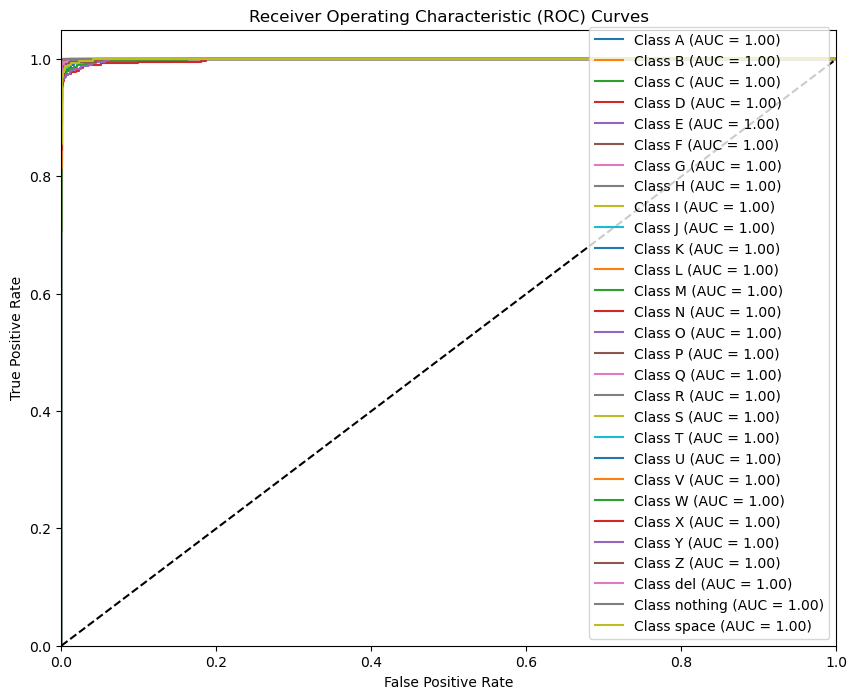

In [76]:


n_classes = len(asl_classes) 
y_true = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], np.array(y_scores)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {asl_classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()